In [13]:
!pip install torch-geometric

In [14]:
from torch_geometric.utils import from_networkx

def prepare_graph_data(G):
    """
    Prepares the graph data for use in a GCN model.
    Converts a NetworkX graph to PyTorch Geometric format.

    Args:
        G (networkx.Graph): The input NetworkX graph.

    Returns:
        x (torch.Tensor): The node feature matrix.
        edge_index (torch.Tensor): The edge indices.
        node_to_idx (dict): A mapping from node to its index.
    """
    # Convert the NetworkX graph to PyTorch Geometric data
    data = from_networkx(G)
    
    # Generate a dummy feature matrix if no features exist
    if 'x' not in data or data.x is None:
        num_nodes = G.number_of_nodes()
        data.x = torch.eye(num_nodes)  # Identity matrix as dummy features

    # Ensure edge_index is properly set
    edge_index = data.edge_index

    # Map nodes to indices
    node_to_idx = {node: i for i, node in enumerate(G.nodes())}

    return data.x, edge_index, node_to_idx


User 45 has purchased:
- Item 598811011: Dingo tank
- Item 189616006: Heavy jsy long leg
- Item 598517002: SANDY shorts
- Item 633808016: Terrier tee TOP PRODUCT
- Item 443696021: BO basic OH BB


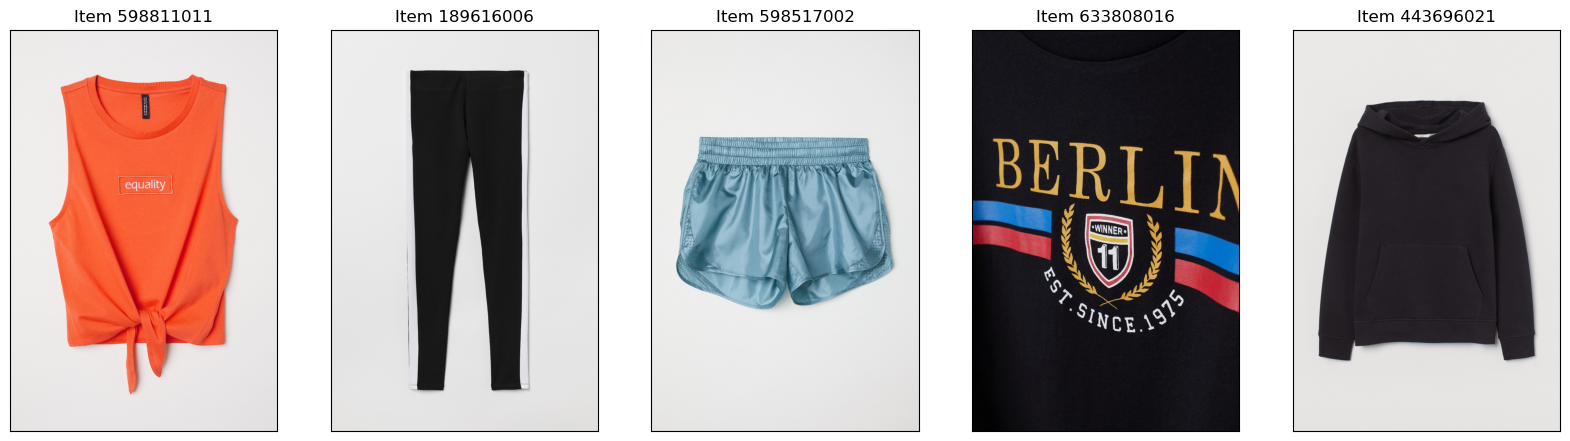


Recommended items for user 45:
- Item 217727002: Polly 3p minishaftless with similarity score: 1.0000
- Item 864668004: Cat cotton tee with similarity score: 1.0000
- Item 568597006: Hayes slim trouser with similarity score: 1.0000
- Item 745475001: Sorrel(1) with similarity score: 1.0000
- Item 507910004: Isabella with similarity score: 1.0000


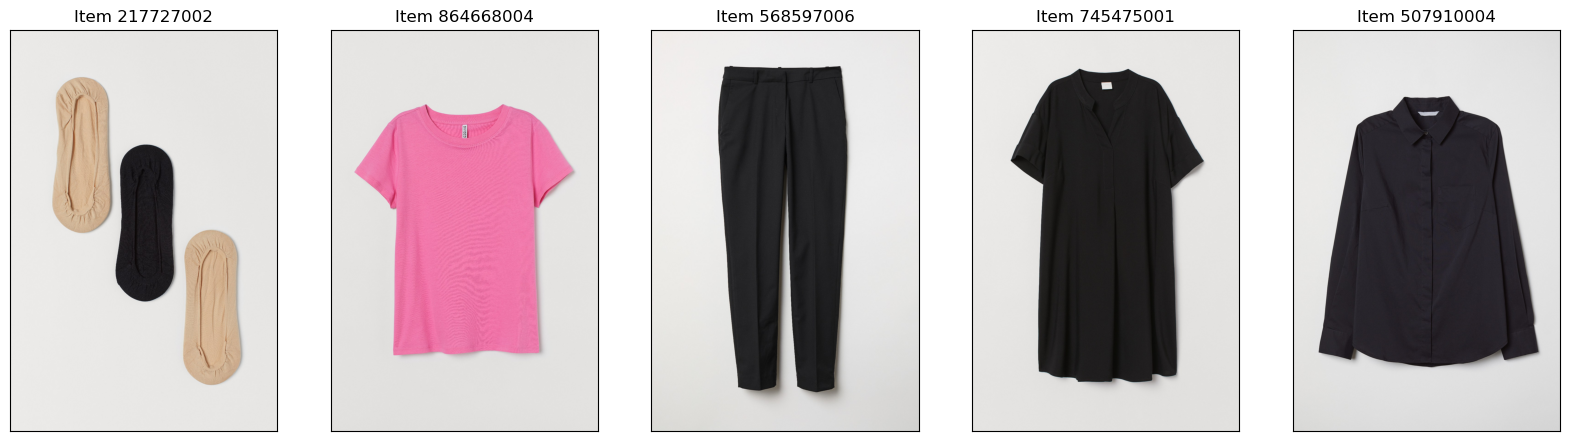

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg


# Data Preparation
def load_data():
    articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
    transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

    # Filter data
    item_freq = transactions.groupby('article_id')['customer_id'].nunique()
    user_freq = transactions.groupby('customer_id')['article_id'].nunique()

    items = item_freq[item_freq >= 100].index
    users = user_freq[user_freq >= 100].index

    filtered_df = transactions[transactions['article_id'].isin(items) & transactions['customer_id'].isin(users)]

    freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')
    GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')
    GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

    unique_customer_ids = GraphTravel_HM['customer_id'].unique()
    customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
    GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

    item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))

    return GraphTravel_HM, item_name_mapping


# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


# Graph Data Preparation
def prepare_graph_data(G):
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    edge_index = []
    for edge in G.edges():
        edge_index.append([node_to_idx[edge[0]], node_to_idx[edge[1]]])
        edge_index.append([node_to_idx[edge[1]], node_to_idx[edge[0]]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.eye(len(nodes), dtype=torch.float)

    return x, edge_index, node_to_idx


def generate_embeddings(GraphTravel_HM):
    G = nx.Graph()

    for _, row in GraphTravel_HM.iterrows():
        G.add_node(row['customer_id'], type='user')
        G.add_node(row['article_id'], type='item')
        G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

    x, edge_index, node_to_idx = prepare_graph_data(G)

    input_dim = x.size(1)
    hidden_dim = 128
    output_dim = 128

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(x, edge_index)

        # Loss: Compare output embeddings for connected nodes
        loss = 0
        for edge in edge_index.t():
            node_u, node_v = edge
            loss += F.mse_loss(out[node_u], out[node_v])

        loss /= edge_index.size(1)  # Normalize by the number of edges
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        final_embeddings = model(x, edge_index)

    # Convert embeddings to a dictionary
    embeddings = {node: final_embeddings[node_to_idx[node]].numpy() for node in G.nodes()}
    return embeddings



# Recommendation Functions
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])


def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = embeddings[user_id]

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items and item_id in embeddings:
            item_embedding = embeddings[item_id]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities


def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20, 10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping.get(item_id, 'Unknown')}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity:.4f}")
        else:
            print()
        img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()


def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    rated_items = get_rated_items(user_id, df)
    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))

    item_similarities = calculate_similarities(user_id, df, embeddings)
    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


# Main Execution
GraphTravel_HM, item_name_mapping = load_data()
embeddings = generate_embeddings(GraphTravel_HM)
recommend_items(45, GraphTravel_HM, embeddings, item_name_mapping, num_items=5)


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg


# Data Preparation
def load_data():
    articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
    transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

    # Filter data
    item_freq = transactions.groupby('article_id')['customer_id'].nunique()
    user_freq = transactions.groupby('customer_id')['article_id'].nunique()

    items = item_freq[item_freq >= 100].index
    users = user_freq[user_freq >= 100].index

    filtered_df = transactions[transactions['article_id'].isin(items) & transactions['customer_id'].isin(users)]

    freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')
    GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')
    GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

    unique_customer_ids = GraphTravel_HM['customer_id'].unique()
    customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
    GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

    item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))

    return GraphTravel_HM, item_name_mapping


# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


# Graph Data Preparation
def prepare_graph_data(G):
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    edge_index = []
    for edge in G.edges():
        edge_index.append([node_to_idx[edge[0]], node_to_idx[edge[1]]])
        edge_index.append([node_to_idx[edge[1]], node_to_idx[edge[0]]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.eye(len(nodes), dtype=torch.float)

    return x, edge_index, node_to_idx


def generate_embeddings(GraphTravel_HM):
    G = nx.Graph()

    for _, row in GraphTravel_HM.iterrows():
        G.add_node(row['customer_id'], type='user')
        G.add_node(row['article_id'], type='item')
        G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

    x, edge_index, node_to_idx = prepare_graph_data(G)

    input_dim = x.size(1)
    hidden_dim = 128
    output_dim = 128

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(x, edge_index)

        # Loss: Compare output embeddings for connected nodes
        loss = 0
        for edge in edge_index.t():
            node_u, node_v = edge
            loss += F.mse_loss(out[node_u], out[node_v])

        loss /= edge_index.size(1)  # Normalize by the number of edges
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        final_embeddings = model(x, edge_index)

    # Convert embeddings to a dictionary
    embeddings = {node: final_embeddings[node_to_idx[node]].numpy() for node in G.nodes()}
    return embeddings



# Recommendation Functions
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])


def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = embeddings[user_id]

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items and item_id in embeddings:
            item_embedding = embeddings[item_id]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities


def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20, 10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping.get(item_id, 'Unknown')}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity:.4f}")
        else:
            print()
        img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()


def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    rated_items = get_rated_items(user_id, df)
    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))

    item_similarities = calculate_similarities(user_id, df, embeddings)
    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


# Main Execution
GraphTravel_HM, item_name_mapping = load_data()
embeddings = generate_embeddings(GraphTravel_HM)



In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg



class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


# Graph Data Preparation
def prepare_graph_data(G):
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    edge_index = []
    for edge in G.edges():
        edge_index.append([node_to_idx[edge[0]], node_to_idx[edge[1]]])
        edge_index.append([node_to_idx[edge[1]], node_to_idx[edge[0]]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.eye(len(nodes), dtype=torch.float)

    return x, edge_index, node_to_idx


# Generate Embeddings
def generate_embeddings(GraphTravel_HM):
    G = nx.Graph()

    for _, row in GraphTravel_HM.iterrows():
        G.add_node(row['customer_id'], type='user')
        G.add_node(row['article_id'], type='item')
        G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

    x, edge_index, node_to_idx = prepare_graph_data(G)

    input_dim = x.size(1)
    hidden_dim = 128
    output_dim = 128

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(x, edge_index)

        # Loss: Compare output embeddings for connected nodes
        loss = 0
        for edge in edge_index.t():
            node_u, node_v = edge
            loss += F.mse_loss(out[node_u], out[node_v])

        loss /= edge_index.size(1)  # Normalize by the number of edges
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        final_embeddings = model(x, edge_index)

    # Convert embeddings to a dictionary
    embeddings = {node: final_embeddings[node_to_idx[node]].numpy() for node in G.nodes()}
    return embeddings


def load_and_split_data():
    articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
    transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

    # Convert dates to datetime
    transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

    # Split data into train and test based on date
    last_month = transactions['t_dat'].max().replace(day=1)
    print(last_month)
    train_data = transactions[transactions['t_dat'] < last_month]
    test_data = transactions[transactions['t_dat'] >= last_month]

    # Filter items and users with sufficient interactions in the training set
    item_freq = train_data.groupby('article_id')['customer_id'].nunique()
    user_freq = train_data.groupby('customer_id')['article_id'].nunique()

    items = item_freq[item_freq >= 100].index
    users = user_freq[user_freq >= 100].index

    train_data = train_data[train_data['article_id'].isin(items) & train_data['customer_id'].isin(users)]

    # Calculate interaction frequency for train data
    freq = train_data.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')
    GraphTravel_HM = train_data.merge(freq, on=['customer_id', 'article_id'], how='left')
    GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

    # Create mappings
    unique_customer_ids = GraphTravel_HM['customer_id'].unique()
    customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
    GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

    item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))

    return GraphTravel_HM, test_data, item_name_mapping, customer_id_mapping
    
def evaluate_model(test_data, embeddings, customer_id_mapping, top_k=12, output_csv="evaluation_results.csv"):
    test_data['customer_id_mapped'] = test_data['customer_id'].map(customer_id_mapping)

    results = []

    for customer_id, group in test_data.groupby('customer_id_mapped'):
        if customer_id not in embeddings:
            continue
        user_embedding = embeddings[customer_id]
        purchased_items = group['article_id'].unique()

        # Rank items by similarity
        similarities = []
        for item_id in set(test_data['article_id']):
            if item_id in embeddings:
                item_embedding = embeddings[item_id]
                similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
                similarities.append((item_id, similarity))

        # Get top K recommendations
        recommendations = [item for item, _ in sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]]

        # Calculate correct predictions
        correct_predictions = len(set(recommendations) & set(purchased_items))

        # Append results for this customer
        results.append({
            "customer_id": customer_id,
            "predicted_purchase": recommendations,
            "actual_purchase": purchased_items.tolist(),
            "total_purchased": len(purchased_items),
            "outofactual_howmanypredicted": correct_predictions
        })

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

    # Calculate average precision
    total_correct = sum(r["outofactual_howmanypredicted"] for r in results)
    total_actual = sum(len(r["actual_purchase"]) for r in results)
    avg_precision = total_correct / total_actual
    print(f"Average Precision: {avg_precision:.4f}")

    return avg_precision




GraphTravel_HM, test_data, item_name_mapping, customer_id_mapping = load_and_split_data()
evaluate_model(test_data, embeddings, customer_id_mapping, top_k=65, output_csv="evaluation_results.csv")



2020-09-01 00:00:00
Results saved to evaluation_results.csv
Average Precision: 0.031


0.031339556592765463